In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import optuna
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [20]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
data=pd.read_csv('train.csv')
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [21]:
quality_mapping = {
        'Ex': 5,
        'Gd': 4,
        'TA': 3,
        'Fa': 2,
        'Po': 1,
    }
quality_features = ['ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual']
col_keep_mode_impute = ['MSZoning', 'Utilities', 'Electrical', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 'SaleType']
col_keep_zero_fill = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                          'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']
# Handle missing values
def handle_missing_values(df):
    missing_data = df.isnull().sum()
    cols_to_drop = missing_data[missing_data > 5].index
    print("cols to drop: ", cols_to_drop)
    cols_to_keep = missing_data[(missing_data > 0) & (missing_data <= 5)].index
    print("cols to keep: ", cols_to_keep)
    df = df.drop(columns=cols_to_drop)

    for col in cols_to_keep:
        if col in col_keep_mode_impute:
            df[col] = df[col].fillna(df[col].mode()[0])
        elif col in col_keep_zero_fill:
            df[col] = df[col].fillna(0)
        else:
            df[col] = df[col].fillna(df[col].mean())

    print('Missing values left:', df.isnull().sum().max())
    return df

# Feature engineering
def engineer_features(df):
    df['Age'] = df['YrSold'] - df['YearBuilt']
    df['RemodAge'] = df['YrSold'] - df['YearRemodAdd']
    
    return df

def convert_to_numerical(df):
    for feature in quality_features:
        df[feature] = df[feature].map(quality_mapping)

    # Convert remaining categorical variables to numerical using Label Encoding
    label_encoders = {}
    categorical_cols = df.select_dtypes(include=['object']).columns

    for col in categorical_cols:
        label_encoders[col] = LabelEncoder()
        df[col] = label_encoders[col].fit_transform(df[col])
    return df

In [22]:
# handle missing values
data = handle_missing_values(data)
  
# Feature engineering
data = engineer_features(data)

# Convert categorical features to numerical
data = convert_to_numerical(data)

cols to drop:  Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature'],
      dtype='object')
cols to keep:  Index(['Electrical'], dtype='object')
Missing values left: 0


In [24]:
data.corr()['SalePrice'].sort_values(ascending=False)

SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
ExterQual       0.682639
KitchenQual     0.659600
                  ...   
KitchenAbvGr   -0.135907
MSZoning       -0.166872
LotShape       -0.255580
RemodAge       -0.509079
Age            -0.523350
Name: SalePrice, Length: 65, dtype: float64

In [27]:
X = data.drop(['SalePrice', 'Id'], axis=1)
y = data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [57]:
def objective(trial):
    
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'n_estimators': 10000,
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = XGBRegressor(**param)  
    
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred,squared=False)
    
    return rmse

In [58]:
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=50)

[I 2024-07-07 11:57:24,016] A new study created in memory with name: no-name-816fec9d-11d0-4c37-9275-8d6cb6ed6529
[I 2024-07-07 11:57:24,957] Trial 0 finished with value: 35714.30195134168 and parameters: {'lambda': 0.03148911647956861, 'alpha': 6.3512210106407005, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.016, 'max_depth': 9, 'random_state': 2020, 'min_child_weight': 183}. Best is trial 0 with value: 35714.30195134168.
[I 2024-07-07 11:57:25,861] Trial 1 finished with value: 27693.9710840246 and parameters: {'lambda': 0.004809461967501573, 'alpha': 0.0018205657658407262, 'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.014, 'max_depth': 7, 'random_state': 2020, 'min_child_weight': 82}. Best is trial 1 with value: 27693.9710840246.
[I 2024-07-07 11:57:27,027] Trial 2 finished with value: 38919.3418909527 and parameters: {'lambda': 2.065142557895926, 'alpha': 0.026730883107816707, 'colsample_bytree': 0.8, 'subsample': 0.5, 'learning_rate': 0.012, 'max_de

KeyboardInterrupt: 

In [36]:
best_params = study.best_params
best_score = study.best_value
print(f"Best Hyperparameters: {best_params}")
print(f"Best Accuracy: {best_score:.3f}")

Best Hyperparameters: {'lambda': 0.01240590033104614, 'alpha': 0.0016807456139662953, 'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.02, 'max_depth': 13, 'random_state': 2020, 'min_child_weight': 9}
Best Accuracy: 24624.483


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

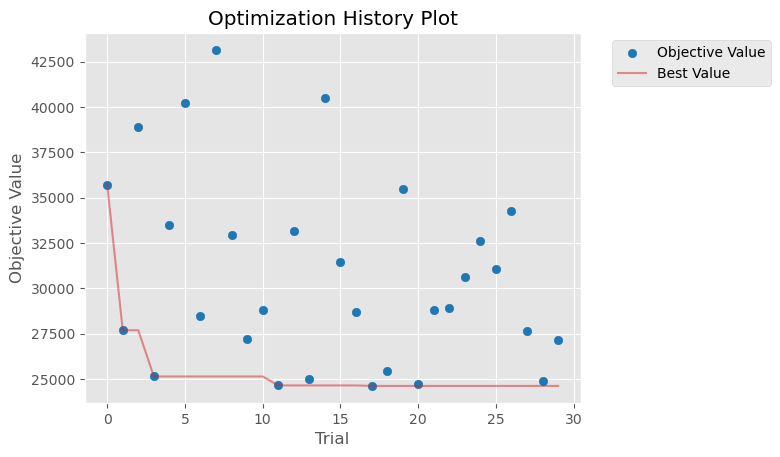

In [44]:
optuna.visualization.matplotlib.plot_optimization_history(study)

<Axes: title={'center': 'Parallel Coordinate Plot'}>

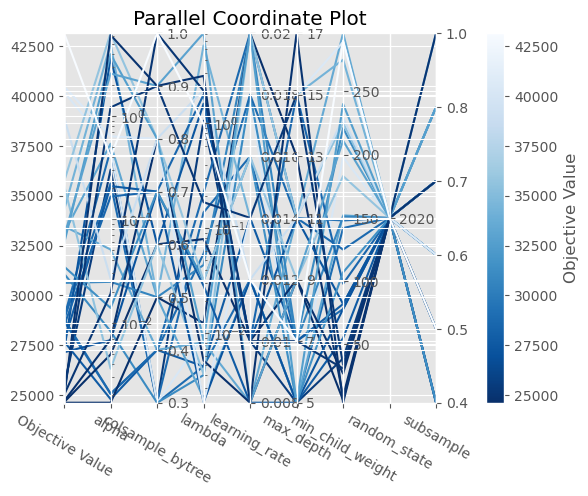

In [45]:
#We can also study the relationship between each value of hyperparameter through this plot
optuna.visualization.matplotlib.plot_parallel_coordinate(study)

array([<Axes: xlabel='alpha', ylabel='Objective Value'>,
       <Axes: xlabel='colsample_bytree'>, <Axes: xlabel='lambda'>,
       <Axes: xlabel='learning_rate'>, <Axes: xlabel='max_depth'>,
       <Axes: xlabel='min_child_weight'>, <Axes: xlabel='random_state'>,
       <Axes: xlabel='subsample'>], dtype=object)

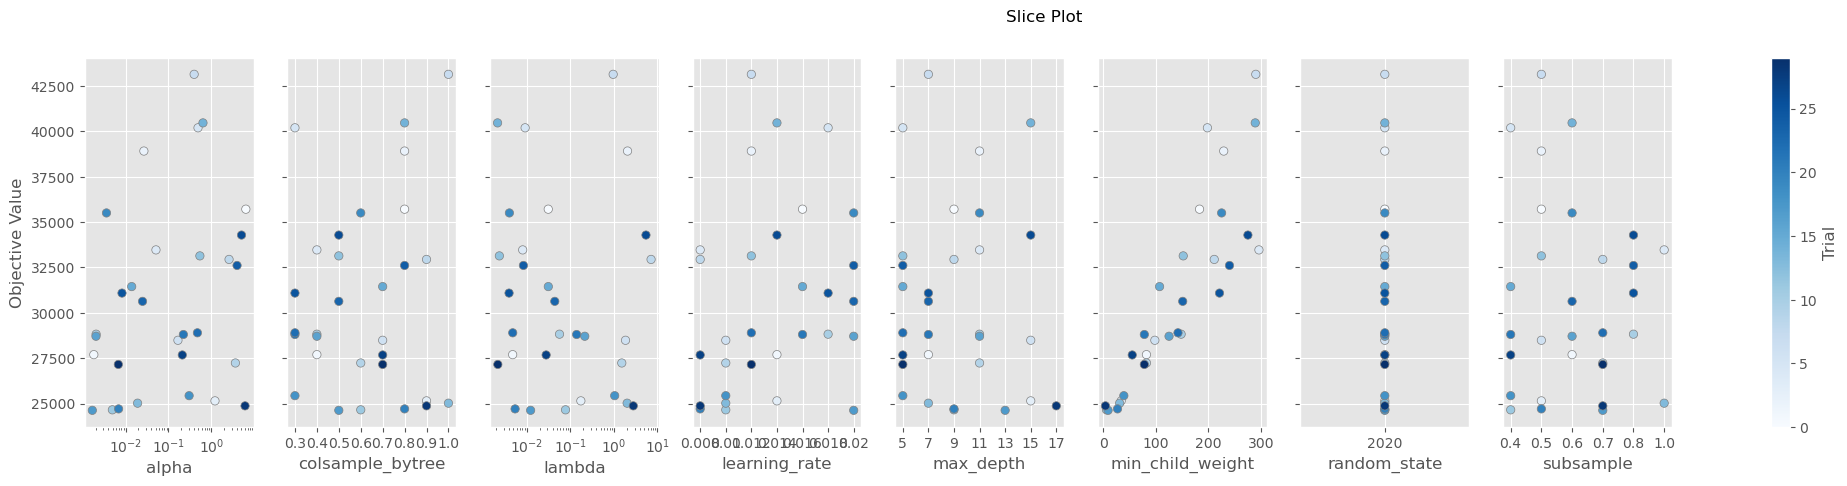

In [46]:
# now we plot the accuracy of each hyperparameter for each trial
optuna.visualization.matplotlib.plot_slice(study)

[W 2024-07-06 22:55:45,960] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


array([[<Axes: ylabel='alpha'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='lambda'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='learning_rate'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='alpha', ylabel='subsample'>,
        <Axes: xlabel='lambda'>, <Axes: xlabel='learning_rate'>,
        <Axes: xlabel='subsample'>]], dtype=object)

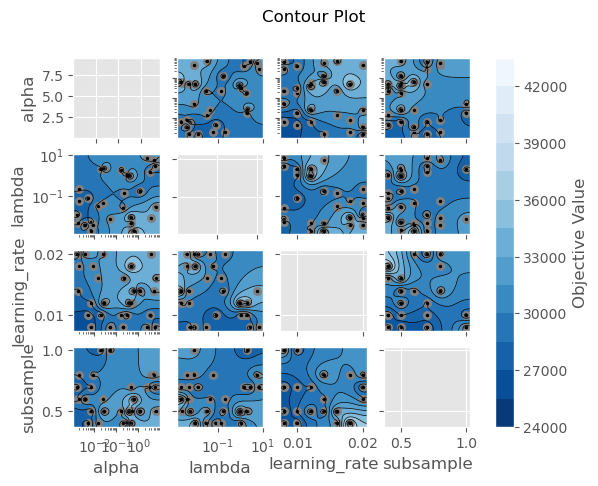

In [48]:
#plotting the accuracy surface for the hyperparameter involved in the xgb
optuna.visualization.matplotlib.plot_contour(study, params=['alpha',
                            'lambda',
                            'subsample',
                            'learning_rate',
                            'subsample'])

<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

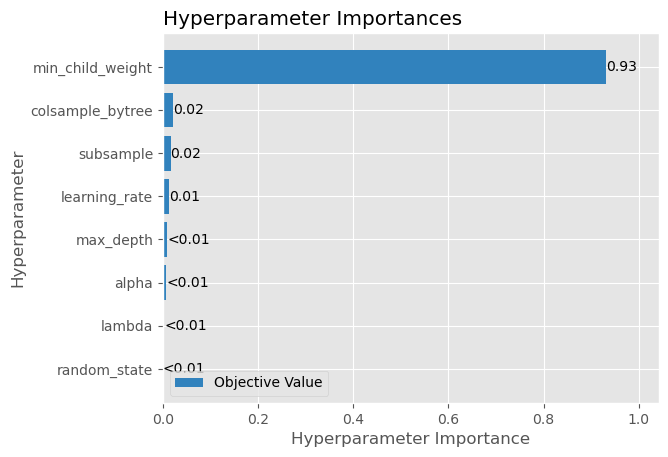

In [49]:
#Now we can look at the role of each parameter in this process
optuna.visualization.matplotlib.plot_param_importances(study)

In [50]:
#fetching the best values
best_lambda = best_params['lambda']
best_alpha = best_params['alpha']
colsample_bytree = best_params['colsample_bytree']
subsample = best_params['subsample']
learning_rate = best_params['learning_rate']
max_depth = best_params['max_depth']
random_state = best_params['random_state']
min_child_weight = best_params['min_child_weight']

In [51]:
best_model = XGBRegressor(
    reg_lambda=best_lambda,
    alpha=best_alpha,
    colsample_bytree=colsample_bytree,
    subsample=subsample,
    learning_rate=learning_rate,
    max_depth=max_depth,
    random_state=random_state,
    min_child_weight=min_child_weight,
    n_estimators=1000
)

# Fitting the model on the training data
best_model.fit(X_train, y_train)

XGBRegressor(alpha=0.0016807456139662953, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.02, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=13, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, ...)

In [52]:
y_pred = best_model.predict(X_test)

In [53]:
mean_absolute_error(y_test, y_pred)

16140.23065603596

In [54]:
mean_squared_error(y_test, y_pred)

615120142.5202657

In [55]:
r2_score(y_test, y_pred)

0.9038420551132332

In [56]:
r2_scores = cross_val_score(best_model, X_test, y_test, n_jobs=-1, cv=5, scoring='r2')
mean_r2_score = r2_scores.mean()
print("Mean R² score:", mean_r2_score)

Mean R² score: 0.8718741981880337
